In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from tqdm import tqdm

In [2]:
# dataset generation

In [3]:
def generate_task_subsets(num_tasks, num_bits, task_sizes, random_state = 0):
  np.random.seed(random_state)
  task_subsets = np.zeros((num_tasks, num_bits))
  for i in range(num_tasks):
    task_subsets[i][np.random.choice(num_bits, size = task_sizes[i], replace = False)] = 1
  return task_subsets

def create_dataset(num_tasks, num_bits, task_freq, task_subsets, num_samples, num_batches = 1, random_state = 0):
  np.random.seed(random_state)
  # generate task-subsets
  # task_subsets = np.zeros((num_tasks, num_bits))
  # for i in range(num_tasks):
  #   task_subsets[i][np.random.choice(num_bits, size = task_sizes[i], replace = False)] = 1
  # print("task subsets")
  # print(task_subsets)
  all_tasks = np.arange(num_tasks)

  for i in range(num_batches):
    # sample tasks
    tasks = np.random.choice(all_tasks, size = num_samples, p = task_freq / task_freq.sum())

    # generate control bits with respect to task frequencies
    control_bits = np.eye(num_tasks)[tasks]
    # print("control bit shapes")
    # print(control_bits)
    # print(control_bits.shape)

    # generate task strings
    task_bits = np.random.randint(2, size = (num_samples, num_bits))
    # print("task bit shapes")
    # print(task_bits)
    # print(task_bits.shape)

    # generate output strings
    task_masks = task_subsets[tasks]
    # print("task mask shapes")
    # print(task_masks)
    # print(task_masks.shape)
    
    out = np.sum(task_bits * task_masks, axis = 1) % 2
    input = np.concatenate([control_bits, task_bits], axis = 1)
    # print(input.shape)

    yield input, out

In [4]:
[x for x in create_dataset(2, 4, np.array([1, 1]), generate_task_subsets(2, 4, np.array([1, 4])), num_samples = 3, num_batches = 2)]

[(array([[0., 1., 1., 1., 1., 1.],
         [0., 1., 1., 0., 0., 1.],
         [0., 1., 0., 0., 0., 0.]]),
  array([0., 0., 0.])),
 (array([[1., 0., 0., 1., 1., 1.],
         [0., 1., 1., 0., 1., 0.],
         [0., 1., 1., 0., 1., 1.]]),
  array([1., 0., 1.]))]

# Trying to train one model to reproduce results in paper

In [5]:
batches = 10000
num_tasks = 500
n = 100
alpha = 0.4

mlp = nn.Sequential(
    nn.Linear(num_tasks + n, 500),
    nn.ReLU(),
    nn.Linear(500, 2)
)

optimizer = torch.optim.Adam(mlp.parameters(), lr = 1e-3)
loss_func = nn.CrossEntropyLoss(reduction = "mean")

# power law scaling with uniform task hardness
power_law = (np.arange(num_tasks) + 1) ** (-alpha - 1)
power_law = power_law / power_law.sum()
task_subsets = generate_task_subsets(num_tasks, n, np.ones(num_tasks, int) * 3)
train_data = create_dataset(500, 100, power_law, task_subsets, 20000, batches)

# uniform frequency, varied task hardness
# frequencies = np.ones(num_tasks)
# frequencies = frequencies / frequencies.sum()
# subset_sizes = np.arange(100)
# task_subsets = generate_task_subsets(num_tasks, n, subset_sizes)
# train_data = create_dataset(num_tasks, n, frequencies, task_subsets, 20000, batches)

# test_data = [x for x in create_dataset(500, 100, power_law, task_subsets, 2000, 1, 1)][0]

In [6]:
losses = []
big_losses = []

In [7]:
mps_device = torch.device("mps")
mps_device

device(type='mps')

In [8]:
torch.mps.current_allocated_memory()

0

In [9]:
def eval_subtasks(model, task_subsets, loss_func, samples_per_task = 50):
  n_tasks = task_subsets.shape[0]
  n = task_subsets.shape[1]

  task_bits = np.random.randint(2, size = (samples_per_task * n_tasks, n))
  output_bits = np.zeros(samples_per_task * n_tasks, dtype = int)
  # create outputs for every subtask
  for i in range(n_tasks):
    input_slice = task_bits[i * samples_per_task : (i + 1) * samples_per_task]
    outputs = np.sum(input_slice * task_subsets[i], axis = 1) % 2
    output_bits[i * samples_per_task:(i + 1) * samples_per_task] = outputs
  input_bits = np.eye(n_tasks)[np.repeat(np.arange(n_tasks), samples_per_task)]
  # print(input_bits.shape)

  total_input = np.concatenate([input_bits, task_bits], axis = 1)
  # calculate the loss for each (in bits)
  mod_outputs = model(torch.from_numpy(total_input).float().to(mps_device))
  loss = loss_func(mod_outputs, torch.from_numpy(output_bits).long().to(mps_device))
  # print(loss.shape)
  # return loss in bits for every subtask
  loss = loss.cpu()

  losses = loss.reshape(-1, samples_per_task).mean(axis = 1) / np.log(2)
  # print(losses.shape)
  return losses


In [10]:
for i, (x, y) in enumerate(train_data):
  print(f"Batch {i}")
  mlp.train()
  mlp.to(mps_device)
  optimizer.zero_grad()

  x, y = torch.from_numpy(x).float().to(mps_device), torch.from_numpy(y).long().to(mps_device)
  outputs = mlp(x)
  loss = loss_func(outputs, y)
  loss.backward()
  losses.append(loss.item())
  optimizer.step()

  if i % 5 == 0:
    mlp.eval()
    with torch.no_grad():
      big_losses.append(eval_subtasks(mlp, task_subsets, nn.CrossEntropyLoss(reduction = 'none'), 100))


Batch 0
Batch 1
Batch 2
Batch 3
Batch 4
Batch 5
Batch 6
Batch 7
Batch 8
Batch 9
Batch 10
Batch 11
Batch 12
Batch 13
Batch 14
Batch 15
Batch 16
Batch 17
Batch 18
Batch 19
Batch 20
Batch 21
Batch 22
Batch 23
Batch 24
Batch 25
Batch 26
Batch 27
Batch 28
Batch 29
Batch 30
Batch 31
Batch 32
Batch 33
Batch 34
Batch 35
Batch 36
Batch 37
Batch 38
Batch 39
Batch 40
Batch 41
Batch 42
Batch 43
Batch 44
Batch 45
Batch 46
Batch 47
Batch 48
Batch 49
Batch 50
Batch 51
Batch 52
Batch 53
Batch 54
Batch 55
Batch 56
Batch 57
Batch 58
Batch 59
Batch 60
Batch 61
Batch 62
Batch 63
Batch 64
Batch 65
Batch 66
Batch 67
Batch 68
Batch 69
Batch 70
Batch 71
Batch 72
Batch 73
Batch 74
Batch 75
Batch 76
Batch 77
Batch 78
Batch 79
Batch 80
Batch 81
Batch 82
Batch 83
Batch 84
Batch 85
Batch 86
Batch 87
Batch 88
Batch 89
Batch 90
Batch 91
Batch 92
Batch 93
Batch 94
Batch 95
Batch 96
Batch 97
Batch 98
Batch 99
Batch 100
Batch 101
Batch 102
Batch 103
Batch 104
Batch 105
Batch 106
Batch 107
Batch 108
Batch 109
Batch 110


In [11]:
import matplotlib.pyplot as plt

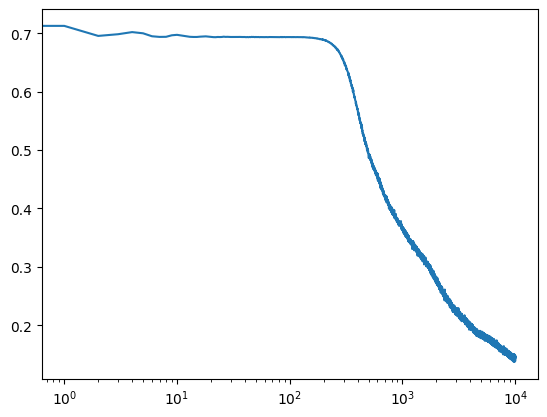

In [12]:
plt.plot(np.arange(len(losses)), losses)
plt.xscale("log")

In [13]:
big_losses = np.array([bl.numpy() for bl in big_losses])

In [14]:
big_losses.shape

(2000, 500)

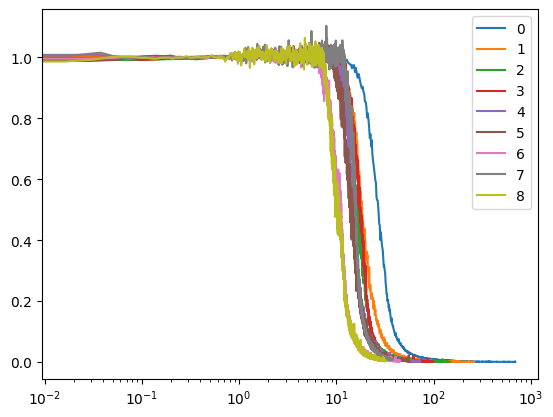

In [24]:
for i in range(9):
  plt.plot(np.arange(big_losses.shape[0]) * power_law[i], big_losses[:, i], label = i)
plt.legend()
plt.xscale("log")

In [30]:
mlp.eval()

Sequential(
  (0): Linear(in_features=600, out_features=500, bias=True)
  (1): ReLU()
  (2): Linear(in_features=500, out_features=2, bias=True)
)

In [33]:
mlp[0].weight.shape # (500, 600)
# x: (600, 1); X: (m, 600) -> Wx or XW^t
# want to see: representation of x = (0)_500 (0..1..0)_100
# Wx -> column of W
# want PCA of last 100 columns of W

torch.Size([500, 600])

In [56]:
col_last = mlp[0].weight[:, -100:].cpu().detach().numpy()
col_last.shape

(500, 100)

In [40]:
from sklearn.decomposition import PCA

In [62]:
pca = PCA(n_components=3)
pca.fit(col_last.T)

PCA(n_components=3)

In [63]:
pca_col_last = pca.transform(col_last.T)
control_bits = mlp[0].weight[:, :-100].cpu().detach().numpy() # (500, 500)
pca_control = pca.transform(control_bits.T)

In [64]:
pca_col_last.shape

(100, 3)

In [65]:
pca.explained_variance_ratio_

array([0.11903442, 0.07464581, 0.06089771], dtype=float32)

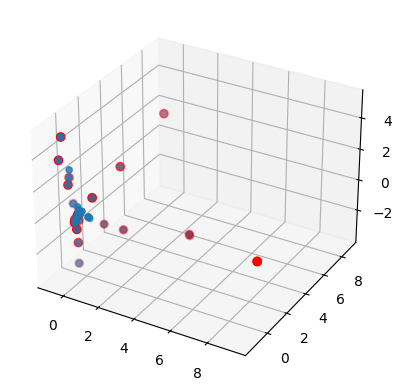

In [72]:
fig = plt.figure()
ax = fig.add_subplot(projection = '3d')
ax.scatter(pca_col_last[:, 0], pca_col_last[:, 1], pca_col_last[:, 2])
for i in range(10):
    inds = np.where(task_subsets[i] != 0)
    ax.scatter(pca_col_last[inds[0], 0], pca_col_last[inds[0], 1], pca_col_last[inds[0], 2], color = "red", s = 36)

(array([ 2, 26, 86]),)